# Data Cleaning 

## Objectives
- Clean dataset in preparation for analysis and modelling

## Inputs 
- outputs/datasets/collection/HousingPrices.csv

## Outputs
- outputs/datasets/cleaned/HousingPrices.csv
- outputs/datasets/cleaned/Test.csv
- outputs/datasets/cleaned/Train.csv

---

## Change working directory

In [1]:
import os 
cwd = os.getcwd()
cwd

'/workspaces/heritage-housing/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(cwd))
print("You set a new current working directory")


You set a new current working directory


In [3]:
cwd = os.getcwd()
cwd

'/workspaces/heritage-housing'

---

## Load data

In [4]:
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/HousingPrices.csv")
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,SalePrice,HouseAge,RemodAge,GarageAge,TotalSF,AboveGradeSF,IsRemodeled,Has2ndFlr,HasPorch,HasDeck
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,208500,22,22,22.0,2566.0,1710.0,0,1,0,0
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,181500,49,49,49.0,2524.0,1262.0,0,0,0,0
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,223500,24,23,24.0,2706.0,1786.0,1,1,0,0
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,140000,110,55,27.0,1717.0,961.0,1,0,0,0
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,250000,25,25,25.0,2290.0,1145.0,0,0,0,0


## Data Exploration

In [5]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtExposure',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF',
 'GarageAge']

In [6]:
from ydata_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 49.54it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Assessing Missing Data Levels

In [7]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

In [8]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,235,16.10,object
BsmtFinType1,145,9.93,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageAge,81,5.55,float64
BsmtExposure,38,2.60,object
MasVnrArea,8,0.55,float64


Observations:
- EnclosedPorch and WoodDeckSF have severe levels of missing data. It would be most sensible to drop these fields before any analysis or modelling. 
- Categorical variables with missing data are GarageFinish, BsmtFinType1 and BsmtExposure - we should use a CategoricalImputer for these variables.
- Numerical variables with missing data are LotFrontage, BedroomAbvGr, 2ndFlrSF, GarageAge and MasVnrArea - we should use a MeanMedianImputer or ArbitraryNumberImputer for these variables.

### Assessing which imputer to use on numerical values

In [9]:
%matplotlib inline

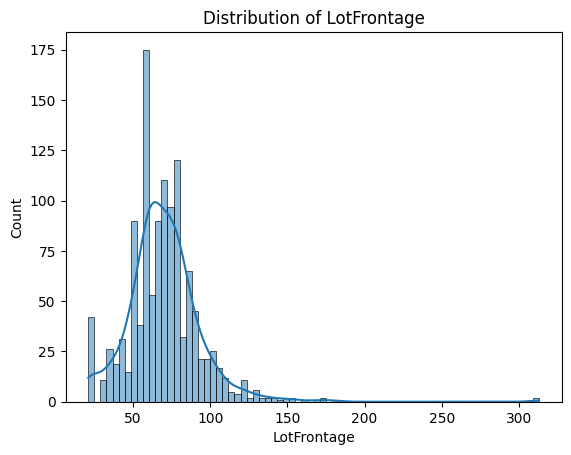

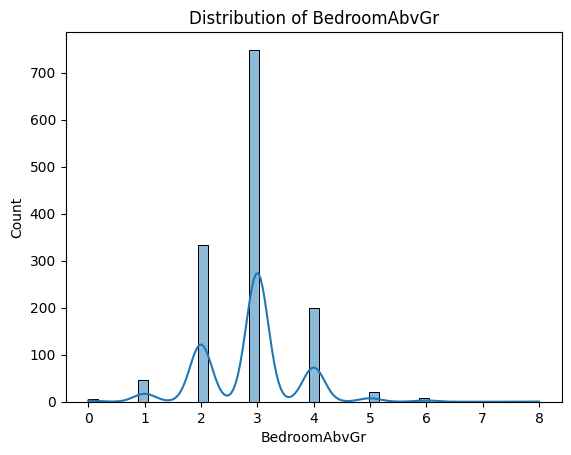

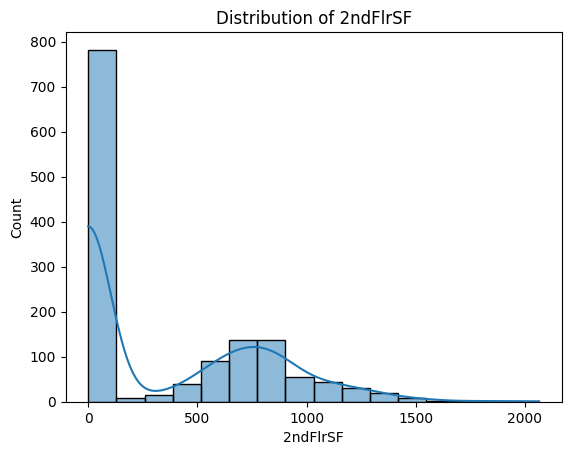

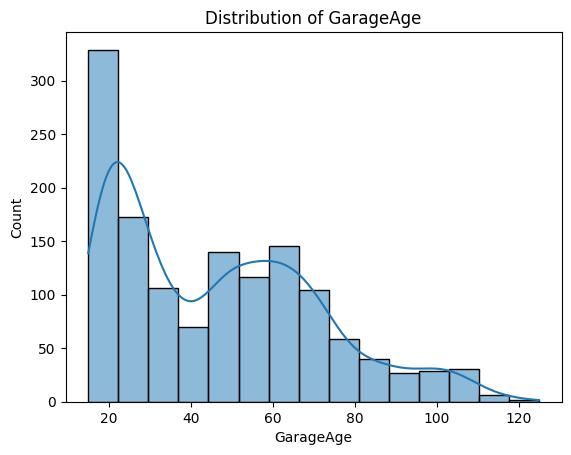

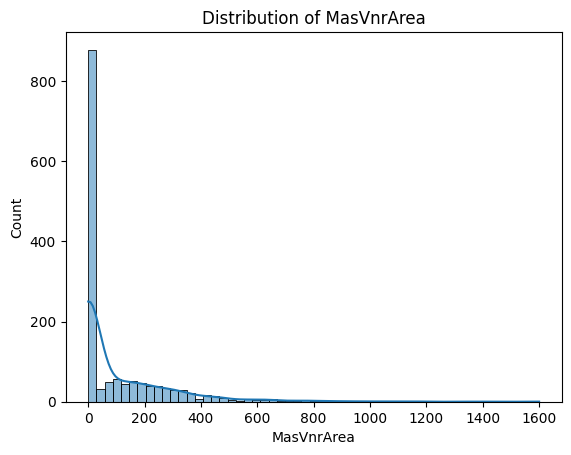

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_variables_missing = ['LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'GarageAge', 'MasVnrArea']

for i in numerical_variables_missing:
    sns.histplot(df[i].dropna(), kde=True)
    plt.title(f"Distribution of {i}")
    plt.show()

Observations: 
- 2ndFlrSF and GarageAge can be filled with 0. This will be more meaningful than filling with the median, since it likely represents the lack of 2nd floor/garage.
- It is likely the missing values for LotFrontage, BedroomAbvGr and MasVnrArea are due to data entry missing, rather than the value is 0, so a MeanMedianImputer works best. We will use a median imputer since these variables are not normally distributed. 

## Handling missing data 
### Numerical variables